In [17]:
ACTIONS = 3 # 0 - Do Nothing, 1 - Duck, 2 - Jump
GAMMA = 0.99
OBSERVATION = 100 # Number of Observations before beginning the training
EXPLORE = 100000
INITIAL_EPSILON = 0.1
FINAL_EPSILON = 0.00001
REPLAY_MEMORY = 50000 # Number of past states to be stored for training
BATCH_SIZE = 16 # Number of states to be trained on. BATCH_SIZE good case and BATCH_SIZE bad case. Total is 2 * BATCH_SIZE. Total shouold always be less than OBSERVATION
LEARNING_RATE = 1e-4
IMAGE_ROWS = 20 # Input image state row size
IMAGE_COLUMNS = 80 # Input image state column size
IMAGE_CHANNELS = 4 # Number of images to be stacked to make the input state
SAVE_COUNT = 5000 # After SAVE_COUNT iterations save the state of the model and other related objects

In [3]:
import pandas
import os
import pickle
from collections import deque

# Class to store/load all data required for training purpose
class Data:
    def __init__(self):
        self.losses_file_path = "data/losses.csv"
        self.scores_file_path = "data/scores.csv"
        self.actions_file_path = "data/actions.csv"
        self.epsilon_file_path = "data/epsilon.obj"
        self.turn_file_path = "data/turn.obj"
        self.gameStatesRMQ_file_path = "data/gameStatesRMQ.obj"
        self.gameEndStatesRMQ_file_path = "data/gameEndStatesRMQ.obj"
        
        self.loss_df = pandas.DataFrame(columns =['loss'])
        self.scores_df = pandas.DataFrame(columns = ['score'])
        self.actions_df = pandas.DataFrame(columns = ['action'])
        self.epsilon = self.loadObject(self.epsilon_file_path) if os.path.isfile(self.epsilon_file_path) else INITIAL_EPSILON
        self.turn = self.loadObject(self.turn_file_path) if os.path.isfile(self.turn_file_path) else 0
        self.gameStatesRMQ = self.loadObject(self.gameStatesRMQ_file_path) if os.path.isfile(self.gameStatesRMQ_file_path) else deque()
        self.gameEndStatesRMQ = self.loadObject(self.gameEndStatesRMQ_file_path) if os.path.isfile(self.gameEndStatesRMQ_file_path) else deque()
    
    # Saves the object in the given filePath
    def saveObject(self, obj, filePath):
        if filePath.endswith(".obj"):
            with open(filePath, 'wb') as file:
                pickle.dump(obj, file, pickle.HIGHEST_PROTOCOL)
        elif filePath.endswith(".csv"):
            isHeaderNeeded = not os.path.isfile(filePath)
            with open(filePath, 'a') as file:
                obj.to_csv(file, index = False, header = isHeaderNeeded)
            obj.drop(obj.index, inplace = True)
    
    # Loads the object serialized in the given filePath
    def loadObject(self, filePath):
        if filePath.endswith(".obj"):
            with open(filePath, 'rb') as file:
                return pickle.load(file)
        elif filePath.endswith(".csv"):
            return pandas.read_csv(filePath)
    
    # Saves the all the objects of the Data class
    def saveAllObjects(self):
        self.saveObject(self.epsilon, self.epsilon_file_path) # Cache epsilon to avoid repeated randomness in actions
        self.saveObject(self.turn, self.turn_file_path) # Caching time steps
        self.saveObject(self.gameStatesRMQ, self.gameStatesRMQ_file_path) # Saving states
        self.saveObject(self.gameEndStatesRMQ, self.gameEndStatesRMQ_file_path) # Saving end states
        self.saveObject(self.loss_df, self.losses_file_path)
        self.saveObject(self.scores_df, self.scores_file_path)
        self.saveObject(self.actions_df, self.actions_file_path)

In [3]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from io import BytesIO
from PIL import Image
from scipy.misc import imresize
import base64
import numpy
import time

# Agent class interacting with the game
class Agent:
    def __init__(self):
        self.gameUrl = "dino/index.html"
        self.chromeDriverPath = "drivers/chromedriver_mac"
        options = webdriver.ChromeOptions()
        options.add_argument("disable-infobars")
        options.add_argument("--allow-file-access-from-files")
        self.driver = webdriver.Chrome(executable_path = self.chromeDriverPath, chrome_options = options)
        self.driver.get("file://" + os.path.abspath(self.gameUrl))
        self.startGame()
    
    def startGame(self):
        self.driver.execute_script("return Runner.instance_.start()")
        time.sleep(.2)
    
    def pauseGame(self):
        self.driver.execute_script("return Runner.instance_.stop()")
    
    def resumeGame(self):
        self.driver.execute_script("return Runner.instance_.play()")
    
    def endGame(self):
        self.driver.quit()
    
    def restartGame(self):
        self.driver.execute_script("return Runner.instance_.restart()")
    
    # Returns a bool representing if the game ended
    def isGameFinished(self):
        return self.driver.execute_script("return Runner.instance_.crashed")
    
    # Returns a bool representing if the game is still being played
    def isPlaying(self):
        return self.driver.execute_script("return Runner.instance_.playing")
    
    # Returns the current score of the game
    def getScore(self):
        return int(self.driver.execute_script("return Runner.instance_.distanceMeter.getActualDistance(Runner.instance_.distanceRan)"))
    
    def jump(self):
        self.driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)
    
    def duck(self):
        self.driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_DOWN)
    
    # Returns the image of the game
    def getGameScreen(self):
        imageInBase64 = self.driver.execute_script("canvasRunner = document.getElementById('main_runner_canvas'); return canvasRunner.toDataURL().substring(22)")
        screen = numpy.array(Image.open(BytesIO(base64.b64decode(imageInBase64))))[:, :, 0]
        image = numpy.zeros(screen.shape)
        image[screen > 50] = 1 # Making the dino and other obstacles white
        image[screen > 150] = 0 # Making everything else other than dino and obstacles to black
        image[:22, -175:] = 0 # Removing the score board from top right
        return imresize(image, (IMAGE_ROWS, IMAGE_COLUMNS, 1)) # Resize to image of (height, width)

In [4]:
# GameState class representing the state of the current game
class GameState:
    def __init__(self, agent, data):
        self.agent = agent
        self.data = data
        self.rewards = [1., 0.2, -0.3] # 0 - Do Nothing, 1 - Duck, 2 - Jump - Stored in float values since model predicts in float
    
    # Takes the current action and returns next state, reward and game end value on performing the action
    def getState(self, action):
        self.data.actions_df.loc[len(self.data.actions_df)] = action
        if action == 1:
            self.agent.duck()
        elif action == 2:
            self.agent.jump()
        image = self.agent.getGameScreen()
        if self.agent.isGameFinished():
            self.data.scores_df.loc[len(self.data.scores_df)] = self.agent.getScore()
            return image, -111., True # For crash the reward is set to a high negative number
        return image, self.rewards[action], False # returns next_state, reward and is_the_game_finished

In [5]:
from keras.models import Sequential
from keras.layers.core import Dense, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.optimizers import Adam
from selenium.common.exceptions import NoSuchWindowException
from selenium.common.exceptions import ElementNotInteractableException
import random

# Controller class used to build models, load weights and train the network. This class creates all the required objects
class Controller:
    def __init__(self):
        self.modelWeights_file_path = "weights/modelWeights.h5"
        self.modelWeightsFinal_file_path = "weights/modelWeightsFinal.h5"
        self.model = self.buildModel()
        self.data = Data() # Data class object
        self.turnCount = self.data.turn
        self.gameState = GameState(Agent(), self.data) # GameState class and Agent objects
        self.startTime = self.endTime = time.time()
    
    # Returns a compiled model
    def buildModel(self):
        model = Sequential()
        model.add(Conv2D(32, (8, 8), padding = 'same', strides = (4, 4), activation = 'relu', input_shape = (IMAGE_ROWS, IMAGE_COLUMNS, IMAGE_CHANNELS)))
        model.add(MaxPooling2D(pool_size = (2, 2)))
        model.add(Conv2D(64, (4, 4), padding = 'same', strides = (2, 2), activation = 'relu'))
        model.add(MaxPooling2D(pool_size = (1, 2)))
        model.add(Conv2D(64, (3, 3), padding = 'same', strides = (1, 1), activation = 'relu'))
        model.add(MaxPooling2D(pool_size = (1, 2)))
        model.add(Flatten())
        model.add(Dense(512, activation = 'relu'))
        model.add(Dense(ACTIONS))
        model.compile(loss = 'mse', optimizer = Adam(lr = LEARNING_RATE))

        if not os.path.isfile(self.modelWeights_file_path):
            model.save_weights(self.modelWeights_file_path)
        return model
    
    # Loads the weights on to the created model
    def loadModelWeights(self, filePath):
        self.model.load_weights(filePath)
        self.model.compile(loss = 'mse', optimizer = Adam(lr = LEARNING_RATE))
    
    # Returns the initial screen when the game begins
    def getInitialState(self):
        initialAction = 0 # Setting the initial action as Do Nothing
        newState, _, _ = self.gameState.getState(initialAction) # Get next step after performing the action
        state = numpy.stack((newState, newState, newState, newState), axis = 2) # Stack 4 images to create placeholder input
        return state.reshape(1, state.shape[0], state.shape[1], state.shape[2])  # 1x20x80x4
    
    # Uses the model and the game state to perform action and stores previous state for training
    def predict(self, inputState):
        action = random.randrange(ACTIONS) if (random.random() <= self.data.epsilon) else numpy.argmax(self.model.predict(inputState))
        newState, reward, gameEnd = self.gameState.getState(action)
        newState = newState.reshape(1, newState.shape[0], newState.shape[1], 1) #1x20x80x1
        nextState = numpy.append(newState, inputState[:, :, :, :3], axis = 3) # append the new image to input stack and remove the first one

        if gameEnd:
            self.data.gameEndStatesRMQ.append((inputState, action, reward, nextState, gameEnd))
            '''
            if len(self.data.gameEndStatesRMQ) > REPLAY_MEMORY: # Generally we won't have REPLAY_MEMORY number of end states. So skipping this
                self.data.gameEndStatesRMQ.popleft()
            '''
        else:
            self.data.gameStatesRMQ.append((inputState, action, reward, nextState, gameEnd))
            if len(self.data.gameStatesRMQ) > REPLAY_MEMORY:
                self.data.gameStatesRMQ.popleft()
        return nextState, gameEnd
    
    # Predicts an action and deals with restarting when the game ends
    def doTrain(self, inputState):
        nextState, gameEnd = self.predict(inputState)
        self.data.turn = self.data.turn + 1
        if gameEnd: #reset game to initial frame if game ends
            self.gameState.agent.restartGame()
            nextState = self.getInitialState()
        return nextState
    
    # Updating the value of epsilon
    def updateEpsilon(self): # After observation period start updating the epsilon value
        if self.data.epsilon > FINAL_EPSILON:
            self.data.epsilon -= (INITIAL_EPSILON - FINAL_EPSILON) / EXPLORE # We reduced the epsilon (exploration parameter) gradually
    
    # Uses the previously stored input states and trains the model.
    def trainBatch(self, batchSize): # train in batches only after the observation period
        totalBatchSize = 2 * batchSize
        endStatesCount = min(len(self.data.gameEndStatesRMQ), random.randint(1, batchSize)) # First we randomize and get some end states which are less in number. After that we choose few normal states.
        miniBatch = random.sample(self.data.gameEndStatesRMQ, endStatesCount) + random.sample(self.data.gameStatesRMQ, totalBatchSize - endStatesCount) # Create mini batch to train
        random.shuffle(miniBatch) # Shuffel the selected states
        inputs = numpy.zeros((totalBatchSize, IMAGE_ROWS, IMAGE_COLUMNS, IMAGE_CHANNELS)) # 2 * BATCH_SIZE, 20, 80, 4
        targets = numpy.zeros((totalBatchSize, ACTIONS)) # 2 * BATCH_SIZE, ACTIONS

        # Now we do the experience replay
        for i in range(0, totalBatchSize):
            inputState, action, reward, nextState, gameEnd = miniBatch[i]
            inputs[i:i + 1] = inputState
            targets[i] = self.model.predict(inputState)
            targets[i, action] = reward if gameEnd else reward + GAMMA * numpy.max(self.model.predict(nextState)) # In case of crashed state, we just have the negative reward else predict q values for next state and use it in calculating reward for the current state
        self.data.loss_df.loc[len(self.data.loss_df)] = self.model.train_on_batch(inputs, targets)
    
    # Save all required objects in specific files
    def save(self):
        self.endTime = time.time()
        print("Total iterations saved: {}. Iterations saved in current cycle: {}. Time Taken: {} seconds.".format(self.data.turn, self.data.turn - self.turnCount, self.endTime - self.startTime))
        self.model.save_weights(self.modelWeights_file_path, overwrite = True)
        self.data.saveAllObjects()
        self.turnCount = self.data.turn
        self.startTime = time.time()
        
    # Similar to doTrain but called only when we need to save. Saving by pausing the game causes interruption in game and we get weird results. So we save only when the game ends.
    def doTrainAndSave(self, inputState):
        state = inputState
        gameEnd = False
        while not gameEnd:
            self.updateEpsilon()
            self.trainBatch(BATCH_SIZE)
            state, gameEnd = self.predict(state)
            self.data.turn = self.data.turn + 1
        self.save()
        self.gameState.agent.restartGame()
        return self.getInitialState()
    
    # Function to be called to begin the training. To stop the training, close the browser window.
    def trainNetwork(self):
        try:
            self.loadModelWeights(self.modelWeights_file_path) # Load the weights before beginning of each training session.
            self.startTime = time.time()
            state = self.getInitialState()

            while self.data.turn < OBSERVATION: # Initially we observe before training
                state = self.doTrain(state)

            while (True): # Endless running and training
                self.updateEpsilon()
                self.trainBatch(BATCH_SIZE)
                state = self.doTrain(state)
                
                # save progress every SAVE_COUNT iterations
                if self.data.turn % SAVE_COUNT == 0: # When we have to save, we wait till the current game ends and then save
                    state = self.doTrainAndSave(state)
        except (TypeError, AttributeError, NoSuchWindowException, ElementNotInteractableException) as e:
            self.save() # If game ends abruptly, we save the state
            self.gameState.agent.endGame() # Ending the game and closing the window
            print("Browser window closed. Shutting down.")
    
    # Function to play the game after training. While playing we do not train the model in batches.
    def playGame(self, num = 1):
        try:
            if os.path.isfile(self.modelWeightsFinal_file_path):
                self.loadModelWeights(self.modelWeightsFinal_file_path)
                gameCount = 0
                while gameCount < num: # Play the game for num times.
                    state = self.getInitialState()
                    gameEnd = False
                    while not gameEnd:
                        state, gameEnd = self.predict(state)
                    gameCount += 1
                    print("Game {} ended. Score: {}.".format(gameCount, self.gameState.agent.getScore()))
                    if gameCount < num:
                        self.gameState.agent.restartGame()
                    
            else:
                print("No final weights found. Please create a model weights file by training the model and place it in ", self.modelWeightsFinal_file_path)
            
            self.gameState.agent.endGame()
        except (TypeError, AttributeError, NoSuchWindowException, ElementNotInteractableException) as e:
            self.gameState.agent.endGame() # Clean up if there is any interruption or the game ends abruptly.
            print("Browser window closed. Shutting down.")

Using TensorFlow backend.


In [18]:
Controller().trainNetwork()

/Users/adandapat/miniconda2/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: use options instead of chrome_options
/Users/adandapat/miniconda2/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:59: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


Total iterations saved: 920142. Iterations saved in current cycle: 4509. Time Taken: 382.73316287994385 seconds.
Total iterations saved: 925294. Iterations saved in current cycle: 5152. Time Taken: 409.20445799827576 seconds.
Total iterations saved: 930077. Iterations saved in current cycle: 4783. Time Taken: 377.95569705963135 seconds.
Total iterations saved: 935098. Iterations saved in current cycle: 5021. Time Taken: 395.120069026947 seconds.
Total iterations saved: 940124. Iterations saved in current cycle: 5026. Time Taken: 396.140340089798 seconds.
Total iterations saved: 945171. Iterations saved in current cycle: 5047. Time Taken: 400.1024649143219 seconds.
Total iterations saved: 950493. Iterations saved in current cycle: 5322. Time Taken: 422.6237280368805 seconds.
Total iterations saved: 955862. Iterations saved in current cycle: 5369. Time Taken: 423.7677721977234 seconds.
Total iterations saved: 960231. Iterations saved in current cycle: 4369. Time Taken: 349.9208381175995 

In [4]:
def plotGraph():
    data = Data()
    scores = data.loadObject(data.scores_file_path)
    print("Maximum Score: ", scores.max())
    meanScores = pandas.DataFrame(columns = ['meanScore'])
    maxScores = pandas.DataFrame(columns = ['maxScore'])
    start = 0
    interval = 10
    while interval <= len(scores):
        meanScores.loc[len(meanScores)] = (scores.loc[start : interval].mean()['score'])
        maxScores.loc[len(maxScores)] = (scores.loc[start : interval].max()['score'])
        start = interval
        interval = interval + 10
    meanScores.plot()
    maxScores.plot()
    scores.plot()
    losses = data.loadObject(data.losses_file_path)
    losses.plot()

Maximum Score:  score    7911
dtype: int64


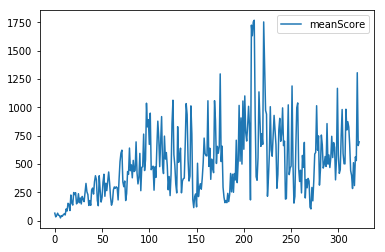

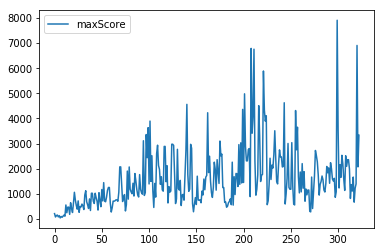

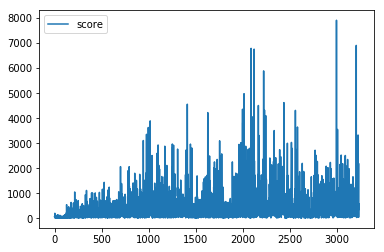

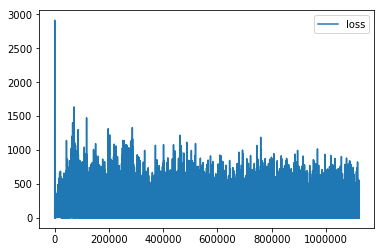

In [6]:
plotGraph()